In [1]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import csv

import contractions
import nltk
from nltk.text import Text
from nltk.corpus import PlaintextCorpusReader
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# import spacy

import re 

In [2]:
df = pd.read_csv('washington_normal_2022.csv')

In [3]:
df

,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,card,viewCount,vibe
0,https://twitter.com/dcexaminer/status/16307191...,2023-02-28 23:58:49+00:00,newsom end california state emergency nearly t...,newsom end california state emergency nearly t...,1630719199935885313,https://twitter.com/dcexaminer,2,3,9,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SummaryCard(title='Newsom ends California COVI...,2008.0,NaN
1,https://twitter.com/layla_abouzaid/status/1630...,2023-02-28 23:58:18+00:00,question everybody making fun many people sayi...,question everybody making fun many people sayi...,1630719070419943424,https://twitter.com/layla_abouzaid,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0,NaN
2,https://twitter.com/foxnewspolitics/status/163...,2023-02-28 23:56:27+00:00,fbi director say covid pandemic likely origina...,fbi director say covid pandemic likely origina...,1630718606840299521,https://twitter.com/foxnewspolitics,10,11,32,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"SummaryCard(title=""FBI director says COVID pan...",5121.0,NaN
3,https://twitter.com/thehill/status/16307185169...,2023-02-28 23:56:06+00:00,john barrasso want congress debriefed energy d...,john barrasso want congress debriefed energy d...,1630718516906131456,https://twitter.com/thehill,12,7,17,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14055.0,NaN
4,https://twitter.com/NewsPolitics/status/163071...,2023-02-28 23:55:58+00:00,fbi director say covid pandemic likely origina...,fbi director say covid pandemic likely origina...,1630718483414540289,https://twitter.com/NewsPolitics,0,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"SummaryCard(title=""FBI director says COVID pan...",415.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10144,https://twitter.com/ryanstruyk/status/14796168...,2022-01-08 00:52:11+00:00,cnn people united state died coronavirus,cnn people united state died coronavirus,1479616891782107142,https://twitter.com/ryanstruyk,9,36,52,0,...,1.479588e+18,https://twitter.com/ryanstruyk,NaN,"Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...",NaN,NaN,NaN,NaN,NaN
10145,https://twitter.com/Aly_Dar8/status/1479587485...,2022-01-07 22:55:20+00:00,cnn make differentiation variant testing coron...,cnn make differentiation variant testing coron...,1479587485416140802,https://twitter.com/Aly_Dar8,1,0,0,0,...,1.479587e+18,https://twitter.com/tylerindian,"[User(username='CNN', id=759251, displayname='...","Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...",NaN,NaN,NaN,NaN,NaN
10146,https://twitter.com/GRevmgbrown4/status/147942...,2022-01-07 12:21:09+00:00,open smartnews read coronavirus omicron update...,open smartnews read coronavirus omicron update...,1479427886478151687,https://twitter.com/GRevmgbrown4,0,1,0,0,...,NaN,NaN,NaN,"Coordinates(longitude=-77.064086, latitude=38....","Place(id='6417871953fa5e86', fullName='Silver ...",NaN,NaN,SummaryCard(title='Coronavirus omicron updates...,NaN,NaN
10147,https://twitter.com/AndrewSolender/status/1478...,2022-01-03 17:02:10+00:00,capitol physician say alert staff unprecedente...,capitol physician say alert staff unprecedente...,1478049054307373062,https://twitter.com/AndrewSolender,2,28,23,1,...,NaN,NaN,NaN,"Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...",NaN,NaN,NaN,NaN,NaN


In [4]:
df.isna().sum()

url                     0
date                    0
rawContent              0
renderedContent         0
id                      0
user                    0
replyCount              0
retweetCount            0
likeCount               0
quoteCount              0
conversationId          0
lang                    0
source                  0
sourceUrl               0
sourceLabel             0
links                7910
media                8316
retweetedTweet      10149
quotedTweet          8856
inReplyToTweetId     6202
inReplyToUser        6202
mentionedUsers       5115
coordinates          1303
place                1303
hashtags             8480
cashtags            10142
card                 8620
viewCount            7660
vibe                10115
dtype: int64

In [3]:
df['rawContent'].fillna('', inplace=True)
df['renderedContent'].fillna('', inplace=True)

In [4]:
## remove specific word HTTP
df['rawContent'] = df['rawContent'].str.replace('covid', '')
df['rawContent'] = df['rawContent'].str.replace('coronavirus', '')

df['renderedContent'] = df['renderedContent'].str.replace('covid', '')
df['renderedContent'] = df['renderedContent'].str.replace('coronavirus', '')

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (10, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 10)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

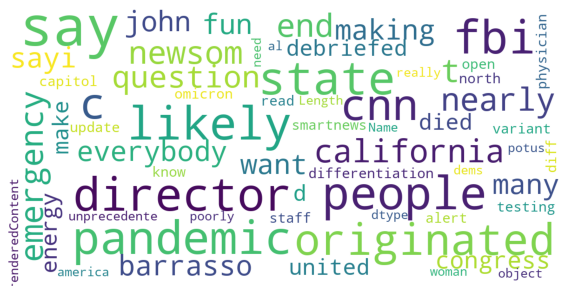

In [8]:
show_wordcloud(df["renderedContent"])

In [5]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [6]:
data = df['renderedContent'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['newsom', 'end', 'california', 'state', 'emergency', 'nearly', 'three', 'year', 'later']


## Building Bi-gram and Tri-gram Models

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [8]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [13]:
data_words_bigrams = make_bigrams(data_words)
data_words_bigrams

[['newsom',
  'end',
  'california',
  'state',
  'emergency',
  'nearly',
  'three',
  'year',
  'later'],
 ['question',
  'everybody',
  'making',
  'fun',
  'many',
  'people',
  'saying',
  'thing',
  'started',
  'even',
  'said',
  'scientist',
  'said',
  'lab',
  'source',
  'lying',
  'scientist',
  'late'],
 ['fbi', 'director', 'say', 'pandemic', 'likely_originated', 'chinese', 'lab'],
 ['john',
  'barrasso',
  'want',
  'congress',
  'debriefed',
  'energy_department',
  'intelligence'],
 ['fbi', 'director', 'say', 'pandemic', 'likely_originated', 'chinese', 'lab'],
 ['jennysfavpal',
  'vigilantfox',
  'martymakary',
  'read',
  'stuff',
  'jeffrey',
  'sack',
  'guy',
  'charge',
  'appointing',
  'scientist',
  'committee',
  'look',
  'origin',
  'fire',
  'scientist',
  'compromised',
  'amp',
  'lied'],
 ['meeting',
  'right',
  'able',
  'leave',
  'work',
  'client',
  'mentioned',
  'bunch',
  'folk',
  'office',
  'gone',
  'happy',
  'hour',
  'dropping',
  'like',

In [9]:
data_words_trigrams = make_trigrams(data_words)
data_words_trigrams

[['newsom',
  'end',
  'california',
  'state',
  'emergency',
  'nearly',
  'three',
  'year',
  'later'],
 ['question',
  'everybody',
  'making',
  'fun',
  'many',
  'people',
  'saying',
  'thing',
  'started',
  'even',
  'said',
  'scientist',
  'said',
  'lab',
  'source',
  'lying',
  'scientist',
  'late'],
 ['fbi', 'director', 'say', 'pandemic', 'likely_originated', 'chinese_lab'],
 ['john',
  'barrasso',
  'want',
  'congress',
  'debriefed',
  'energy_department',
  'intelligence'],
 ['fbi', 'director', 'say', 'pandemic', 'likely_originated', 'chinese_lab'],
 ['jennysfavpal',
  'vigilantfox',
  'martymakary',
  'read',
  'stuff',
  'jeffrey',
  'sack',
  'guy',
  'charge',
  'appointing',
  'scientist',
  'committee',
  'look',
  'origin',
  'fire',
  'scientist',
  'compromised',
  'amp',
  'lied'],
 ['meeting',
  'right',
  'able',
  'leave',
  'work',
  'client',
  'mentioned',
  'bunch',
  'folk',
  'office',
  'gone',
  'happy',
  'hour',
  'dropping',
  'like',
  'fl

## Building rough LDA model 

In [10]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words_trigrams)

# Create Corpus
texts = data_words_trigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]


In [16]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [17]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.009*"new" + 0.008*"variant" + 0.007*"say" + 0.007*"pandemic" + '
  '0.006*"positive" + 0.006*"case" + 0.006*"china" + 0.006*"test" + '
  '0.006*"death" + 0.005*"million"'),
 (1,
  '0.012*"get" + 0.011*"mask" + 0.011*"people" + 0.011*"amp" + 0.010*"got" + '
  '0.009*"vaccine" + 0.009*"day" + 0.009*"like" + 0.009*"test" + 0.008*"year"'),
 (2,
  '0.015*"vaccine" + 0.011*"amp" + 0.009*"people" + 0.005*"tested_positive" + '
  '0.005*"china" + 0.005*"would" + 0.005*"year" + 0.005*"right" + 0.004*"take" '
  '+ 0.004*"still"'),
 (3,
  '0.011*"trump" + 0.009*"biden" + 0.007*"pandemic" + 0.007*"would" + '
  '0.005*"republican" + 0.005*"like" + 0.004*"war" + 0.004*"gop" + '
  '0.004*"news" + 0.004*"economy_inflation_gas"'),
 (4,
  '0.018*"today" + 0.013*"amp" + 0.012*"one" + 0.007*"center" + '
  '0.007*"testing" + 0.006*"booster_rapid_antigen_test" + '
  '0.006*"washingtondc_icymi_via_resident" + 0.006*"well_pcr_test" + '
  '0.006*"access_free_mask" + 0.005*"pandemic"')]


In [18]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_trigrams, dictionary=id2word, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.27852006034915605


## Tuning based on number of topics

In [19]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
       
    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
    # Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_trigrams, dictionary=id2word, 
                                         coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [20]:
# Can take a long time to run. In this case we are going to k_max=14.
import datetime
print(datetime.datetime.now())

from gensim.models import CoherenceModel

coherence_scores = []
model_topics = []

for k in range(2, 20):
    cv = compute_coherence_values(corpus=corpus, dictionary=id2word,k=k) 
    model_topics.append(k)    
    coherence_scores.append(cv)    
    print("#Topics: " + str(k) + ", Score: " + str(coherence_scores[-1]))

print(datetime.datetime.now())

2023-03-12 03:19:58.781916
#Topics: 2, Score: 0.23761581053237762
#Topics: 3, Score: 0.2568610788154358
#Topics: 4, Score: 0.27076130859356595
#Topics: 5, Score: 0.2798791957850736
#Topics: 6, Score: 0.31198271739352984
#Topics: 7, Score: 0.30390960531250116
#Topics: 8, Score: 0.3412410208912682
#Topics: 9, Score: 0.35441781760420504
#Topics: 10, Score: 0.32449908266762506
#Topics: 11, Score: 0.33882556374048517
#Topics: 12, Score: 0.35928759420559836
#Topics: 13, Score: 0.36171391338657405
#Topics: 14, Score: 0.3886035169353373
#Topics: 15, Score: 0.39904465363685093
#Topics: 16, Score: 0.40264860057247864
#Topics: 17, Score: 0.40041214165189165
#Topics: 18, Score: 0.38341792879921016
#Topics: 19, Score: 0.4098263938342555
2023-03-12 03:30:30.834714


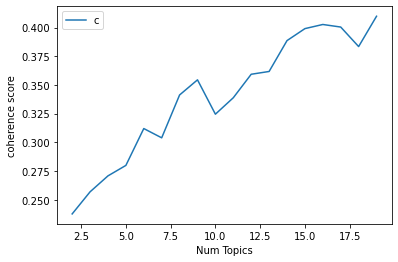

In [21]:
# Show graph

import matplotlib.pyplot as plt

limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_scores)
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend(("coherence score"), loc='best')
plt.show()

In [22]:
end here

SyntaxError: invalid syntax (<ipython-input-22-9bcc9ab561c7>, line 1)

### Final Model

In [11]:
num_topics = 19

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10)

In [12]:
# Save the LDA model

from gensim.test.utils import datapath

lda_model_saved_file = datapath("us_2022_lda_model_19")
lda_model.save(lda_model_saved_file)

In [24]:
score = CoherenceModel(model=lda_model, texts=data_words_trigrams, dictionary=id2word, coherence='c_v')
score.get_coherence()

0.3969900780225124

In [25]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./lda_model/washington_normal_2022_lda_vis_tuned_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './lda_vis/washington_normal_2022_lda_vis_tuned_'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.223694 -0.010211       1        1  12.545746
1      0.259514  0.021147       2        1  10.634665
18     0.219429  0.119291       3        1   8.155186
10     0.010903  0.089527       4        1   6.334580
17     0.093098 -0.035676       5        1   5.892982
0      0.009937 -0.190515       6        1   5.384350
16     0.055552  0.002616       7        1   5.236435
9     -0.016482 -0.066073       8        1   4.852721
13    -0.141890 -0.051330       9        1   4.638307
11    -0.093232 -0.066991      10        1   4.541711
2      0.043033 -0.098419      11        1   4.395664
6     -0.053729 -0.038370      12        1   4.176640
12    -0.049093 -0.166565      13        1   4.067200
15    -0.079451  0.116825      14        1   3.814627
4      0.017350  0.107903      15        1   3.741091
3     -0.091487  0.044793      16        1   3.184812
14    -0.105359 -0.022277      17        1   3.137731
8     -0.144416  0.131382      18        1   2.658388
7     -0.157370  0.112943      19        1   2.607164, topic_info=         Term         Freq        Total Category  logprob  loglift
251      mask   688.000000   688.000000  Default  30.0000  30.0000
495      test   907.000000   907.000000  Default  29.0000  29.0000
227   vaccine  1184.000000  1184.000000  Default  28.0000  28.0000
156     trump   383.000000   383.000000  Default  27.0000  27.0000
38        amp  1471.000000  1471.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
6       state    48.759046   253.944021  Topic19  -4.3437   1.9967
66      leave    28.856558    74.485969  Topic19  -4.8683   2.6986
4217    daily    24.298582    69.089069  Topic19  -5.0402   2.6019
160    course    22.096005    49.915604  Topic19  -5.1352   2.8320
246        oh    21.353988    62.611783  Topic19  -5.1694   2.5712

[1093 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3973      7  0.952404    abc_news
4665     10  0.944744    abortion
2449      6  0.963441  absolutely
510       1  0.050236      access
510      15  0.025118      access
...     ...       ...         ...
1724      6  0.043465         yet
1724      8  0.018628         yet
1724     15  0.707864         yet
4954      2  0.975167     younger
2774      2  0.957257          yr

[2453 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 19, 11, 18, 1, 17, 10, 14, 12, 3, 7, 13, 16, 5, 4, 15, 9, 8])

**Added Sentiment Analysis**

In [13]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [14]:
def determine_sentiment(score):
    if score < 0:
        return "Negative"
    elif score > 0:
        return "Positive"
    else:
        return "Neutral"

In [15]:
sentiment_scores = df['rawContent'].apply(sid.polarity_scores)
sentiment_scores

0        {'neg': 0.245, 'neu': 0.755, 'pos': 0.0, 'comp...
1        {'neg': 0.15, 'neu': 0.705, 'pos': 0.145, 'com...
2        {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3        {'neg': 0.0, 'neu': 0.435, 'pos': 0.565, 'comp...
4        {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
                               ...                        
10144    {'neg': 0.383, 'neu': 0.319, 'pos': 0.298, 'co...
10145    {'neg': 0.083, 'neu': 0.759, 'pos': 0.159, 'co...
10146    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
10147    {'neg': 0.0, 'neu': 0.759, 'pos': 0.241, 'comp...
10148    {'neg': 0.119, 'neu': 0.881, 'pos': 0.0, 'comp...
Name: rawContent, Length: 10149, dtype: object

In [16]:
# Load the saved model

from gensim.test.utils import datapath
lda_model_saved_file = datapath("us_2022_lda_model_19")
lda_model = gensim.models.ldamodel.LdaModel.load(lda_model_saved_file)

In [17]:
topics, num_topics = [], 19

for i in range(len(corpus)):
    top_topics = (
        lda_model.get_document_topics(corpus[i],
                                      minimum_probability=0.0))
    topic_vec = [top_topics[i][1] for i in range(num_topics)]
    topics.append(topic_vec.index(max(topic_vec))+1)
    
topics

[18,
 16,
 7,
 16,
 7,
 15,
 10,
 7,
 16,
 11,
 5,
 4,
 11,
 3,
 1,
 1,
 7,
 7,
 2,
 12,
 17,
 1,
 16,
 14,
 13,
 6,
 8,
 15,
 4,
 16,
 3,
 8,
 8,
 12,
 8,
 7,
 4,
 18,
 10,
 6,
 14,
 4,
 12,
 18,
 12,
 6,
 10,
 16,
 17,
 2,
 14,
 17,
 3,
 14,
 11,
 19,
 15,
 10,
 13,
 10,
 2,
 18,
 8,
 16,
 7,
 15,
 1,
 9,
 15,
 15,
 1,
 16,
 12,
 5,
 16,
 7,
 16,
 6,
 14,
 17,
 14,
 4,
 1,
 13,
 12,
 9,
 16,
 4,
 13,
 4,
 4,
 10,
 18,
 7,
 10,
 10,
 19,
 12,
 6,
 19,
 2,
 5,
 12,
 4,
 10,
 18,
 11,
 11,
 4,
 17,
 5,
 13,
 16,
 11,
 19,
 5,
 4,
 2,
 2,
 10,
 2,
 5,
 19,
 3,
 1,
 5,
 4,
 4,
 19,
 3,
 13,
 5,
 12,
 9,
 4,
 19,
 15,
 18,
 10,
 4,
 6,
 12,
 12,
 7,
 8,
 12,
 8,
 2,
 5,
 10,
 14,
 3,
 10,
 14,
 9,
 19,
 4,
 18,
 10,
 13,
 16,
 2,
 18,
 7,
 10,
 19,
 5,
 18,
 11,
 3,
 1,
 9,
 18,
 16,
 9,
 18,
 17,
 12,
 3,
 6,
 15,
 16,
 1,
 12,
 12,
 16,
 11,
 12,
 11,
 4,
 7,
 16,
 7,
 13,
 4,
 2,
 1,
 8,
 3,
 1,
 3,
 1,
 14,
 8,
 13,
 17,
 7,
 11,
 6,
 10,
 5,
 18,
 2,
 1,
 11,
 5,
 7,
 13,
 2,
 17,
 18

In [18]:
df["Topic"] = topics
df.head()

,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,card,viewCount,vibe,Topic
0,https://twitter.com/dcexaminer/status/16307191...,2023-02-28 23:58:49+00:00,newsom end california state emergency nearly t...,newsom end california state emergency nearly t...,1630719199935885313,https://twitter.com/dcexaminer,2,3,9,1,...,NaN,NaN,NaN,NaN,NaN,NaN,SummaryCard(title='Newsom ends California COVI...,2008.0,NaN,18
1,https://twitter.com/layla_abouzaid/status/1630...,2023-02-28 23:58:18+00:00,question everybody making fun many people sayi...,question everybody making fun many people sayi...,1630719070419943424,https://twitter.com/layla_abouzaid,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0,NaN,16
2,https://twitter.com/foxnewspolitics/status/163...,2023-02-28 23:56:27+00:00,fbi director say pandemic likely originated c...,fbi director say pandemic likely originated c...,1630718606840299521,https://twitter.com/foxnewspolitics,10,11,32,0,...,NaN,NaN,NaN,NaN,NaN,NaN,"SummaryCard(title=""FBI director says COVID pan...",5121.0,NaN,7
3,https://twitter.com/thehill/status/16307185169...,2023-02-28 23:56:06+00:00,john barrasso want congress debriefed energy d...,john barrasso want congress debriefed energy d...,1630718516906131456,https://twitter.com/thehill,12,7,17,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14055.0,NaN,16
4,https://twitter.com/NewsPolitics/status/163071...,2023-02-28 23:55:58+00:00,fbi director say pandemic likely originated c...,fbi director say pandemic likely originated c...,1630718483414540289,https://twitter.com/NewsPolitics,0,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,"SummaryCard(title=""FBI director says COVID pan...",415.0,NaN,7


In [19]:
sentiments = sentiment_scores.apply(lambda x: x["compound"])
sentiment_label = sentiments.apply(determine_sentiment)
df["Sentiment"] = sentiment_label
df.head()

,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,mentionedUsers,coordinates,place,hashtags,cashtags,card,viewCount,vibe,Topic,Sentiment
0,https://twitter.com/dcexaminer/status/16307191...,2023-02-28 23:58:49+00:00,newsom end california state emergency nearly t...,newsom end california state emergency nearly t...,1630719199935885313,https://twitter.com/dcexaminer,2,3,9,1,...,NaN,NaN,NaN,NaN,NaN,SummaryCard(title='Newsom ends California COVI...,2008.0,NaN,18,Negative
1,https://twitter.com/layla_abouzaid/status/1630...,2023-02-28 23:58:18+00:00,question everybody making fun many people sayi...,question everybody making fun many people sayi...,1630719070419943424,https://twitter.com/layla_abouzaid,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,68.0,NaN,16,Negative
2,https://twitter.com/foxnewspolitics/status/163...,2023-02-28 23:56:27+00:00,fbi director say pandemic likely originated c...,fbi director say pandemic likely originated c...,1630718606840299521,https://twitter.com/foxnewspolitics,10,11,32,0,...,NaN,NaN,NaN,NaN,NaN,"SummaryCard(title=""FBI director says COVID pan...",5121.0,NaN,7,Neutral
3,https://twitter.com/thehill/status/16307185169...,2023-02-28 23:56:06+00:00,john barrasso want congress debriefed energy d...,john barrasso want congress debriefed energy d...,1630718516906131456,https://twitter.com/thehill,12,7,17,1,...,NaN,NaN,NaN,NaN,NaN,NaN,14055.0,NaN,16,Positive
4,https://twitter.com/NewsPolitics/status/163071...,2023-02-28 23:55:58+00:00,fbi director say pandemic likely originated c...,fbi director say pandemic likely originated c...,1630718483414540289,https://twitter.com/NewsPolitics,0,0,3,0,...,NaN,NaN,NaN,NaN,NaN,"SummaryCard(title=""FBI director says COVID pan...",415.0,NaN,7,Neutral


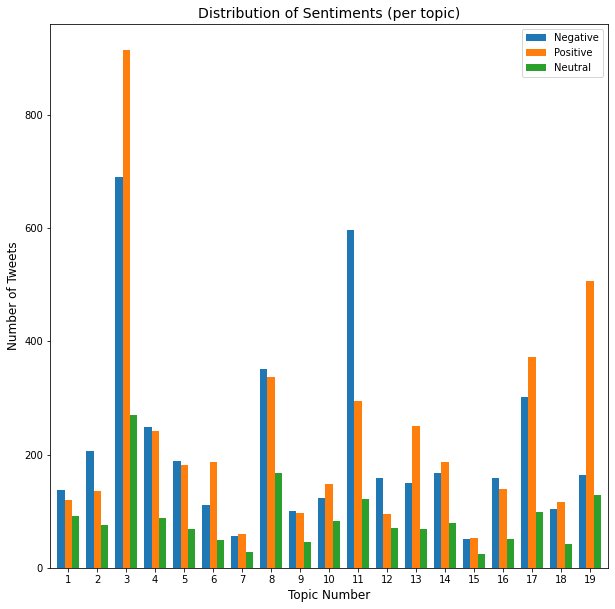

In [20]:
import matplotlib.pyplot as plt

topics = range(1, num_topics+1)
columns = ["Negative", "Positive", "Neutral"]
data = []

for i in range(num_topics):
    curr_topic = df[df["Topic"] == i+1]
    negative, positive, neutral = len(curr_topic[curr_topic["Sentiment"] == "Negative"]), len(curr_topic[curr_topic["Sentiment"] == "Positive"]), len(curr_topic[curr_topic["Sentiment"] == "Neutral"]) 
    data.append([negative, positive, neutral])

topic_sentiment_df = pd.DataFrame(data, columns=columns, index=topics)
topic_sentiment_df.plot(kind="bar", figsize=(10, 10), width=0.75)
plt.title("Distribution of Sentiments (per topic)", fontsize=14)
plt.xlabel("Topic Number", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.gca().xaxis.set_tick_params(rotation=0)
plt.show()